In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchmetrics.functional.regression import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


In [169]:
filename = "../DATA/oil_price.csv"
priceDF = pd.read_csv(filename, encoding="utf-8", parse_dates=["date"])
priceDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10329 non-null  datetime64[ns]
 1   price   10329 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 161.5 KB


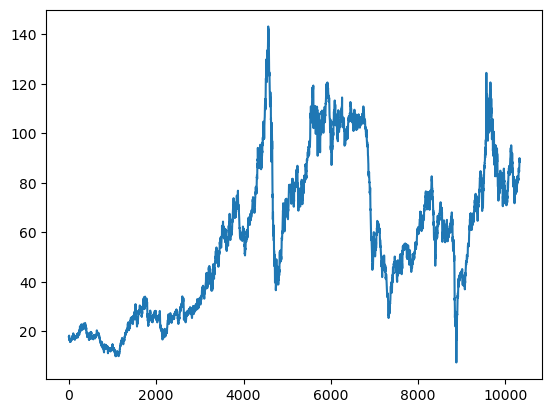

In [170]:
plt.plot(priceDF["price"], label="price")
plt.show()


In [362]:
class OilPriceDataset(Dataset):
    def __init__(self, data, step=365, use_norm=True):
        data = data if isinstance(data, np.ndarray) else data.values
        self.max_data = np.max(data)
        self.min_data = np.min(data)
        self.data = (data - self.min_data) / (self.max_data - self.min_data) if use_norm else data
        self.data = torch.FloatTensor(self.data)
        self.step = step

    def __len__(self):
        return len(self.data) - self.step

    def __getitem__(self, i):
        data = self.data[i : i + self.step]
        label = self.data[i + self.step].squeeze()
        return data, label


In [363]:
class OilPriceModel(nn.Module):
    def __init__(self, hidden_size, num_layers, step):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(in_features=hidden_size*step, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        # x = x[:, -1, :]
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.flatten(x)


In [369]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 32
num_layers = 2
step = 1825
batch_size = 128

model = OilPriceModel(hidden_size, num_layers, step).to(device)
dataset = OilPriceDataset(priceDF[["price"]], step)
loader = DataLoader(dataset, batch_size)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss().to(device)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

len(loader),device


(67, 'cuda')

In [370]:
for i in loader:
    print(i[0].shape)
    print(i[1].shape)
    break


torch.Size([128, 1825, 1])
torch.Size([128])


In [371]:
def learning(epochs, epoch, model, loader, optimizer, loss_fn, is_train=True, use_pabr=True):
    if is_train:
        model.train()
    else:
        model.eval()

    lossList, maeList, mseList, r2List = [], [], [], []
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(loader, total=len(loader)) if use_pabr else loader
        for data, label in pbar:
            pred = model(data.to(device))
            loss = loss_fn(pred, label.to(device))
            lossList.append(loss.item())
            maeList.append(mean_absolute_error(pred, label.to(device)).item())
            mseList.append(mean_squared_error(pred, label.to(device)).item())
            r2List.append(r2_score(pred, label.to(device)).item())
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if use_pabr:
                    pbar.set_description(
                        f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.6f}"
                    )
    return np.mean(lossList), np.mean(maeList), np.mean(mseList), np.mean(r2List)


In [372]:
pre_r2 = 0
pre_loss = 100


In [373]:
epochs = 5000
count = 0
for epoch in range(epochs):
    loss, mae, mse, r2 = learning(
        epochs, epoch, model, loader, optimizer, loss_fn, is_train=True, use_pabr=False
    )
    if epoch % 100 == 99:
        print(
            f"  ==== Loss: {loss:.6f} | MAE: {mae:.6f} | MSE: {mse:.6f} | R2: {r2:.6f} ===="
        )
    if pre_r2 < r2 or (pre_r2 <= r2 and pre_loss > loss):
        torch.save(model, f"oil_price_model_{step}_cuda.pth")
        torch.save(model.state_dict(), f"oil_price_model_state_{step}_cuda.pt")
        if count == 0:
            print(f"Model Saved! => Epoch: {epoch} | R2: {r2:.6f} | Loss: {loss:.6f}")
            count = 10
        elif 0 < count <= 10 :
            count -= 1
        else:
            count = 0
        pre_r2 = r2
        pre_loss = loss
    scheduler.step(loss)


  ==== Loss: 0.001645 | MAE: 0.028379 | MSE: 0.001645 | R2: -0.336751 ====
  ==== Loss: 0.001390 | MAE: 0.026597 | MSE: 0.001390 | R2: -0.057744 ====
Model Saved! => Epoch: 285 | R2: 0.000579 | Loss: 0.001234
Model Saved! => Epoch: 286 | R2: 0.001236 | Loss: 0.001232
Model Saved! => Epoch: 287 | R2: 0.001724 | Loss: 0.001231
Model Saved! => Epoch: 288 | R2: 0.002339 | Loss: 0.001229
Model Saved! => Epoch: 289 | R2: 0.003228 | Loss: 0.001227
Model Saved! => Epoch: 290 | R2: 0.003915 | Loss: 0.001226
Model Saved! => Epoch: 291 | R2: 0.004796 | Loss: 0.001224
Model Saved! => Epoch: 292 | R2: 0.005324 | Loss: 0.001222
Model Saved! => Epoch: 293 | R2: 0.006115 | Loss: 0.001220
Model Saved! => Epoch: 294 | R2: 0.006882 | Loss: 0.001219
Model Saved! => Epoch: 295 | R2: 0.007550 | Loss: 0.001217
Model Saved! => Epoch: 296 | R2: 0.008285 | Loss: 0.001215
Model Saved! => Epoch: 297 | R2: 0.009062 | Loss: 0.001213
Model Saved! => Epoch: 298 | R2: 0.009906 | Loss: 0.001211
  ==== Loss: 0.001210 | 

In [374]:
pre_r2, r2


(0.8024404662758556, 0.8023762231442466)

In [375]:
max_data, min_data = dataset.max_data, dataset.min_data


In [376]:
test_dataset = OilPriceDataset(priceDF[["price"]], step, use_norm=False)
pred_loader = DataLoader(dataset, batch_size=1)
preds = []  # 예측값들을 저장하는 리스트
total_loss = 0
pred_model = torch.load(f"oil_price_model_{step}_cuda.pth", map_location=device)
with torch.no_grad():
    for data, label in pred_loader:
        # 모델의 예측값 출력
        pred = model(data.to(device))
        preds.append(pred.item() * float(max_data - min_data) + float(min_data))


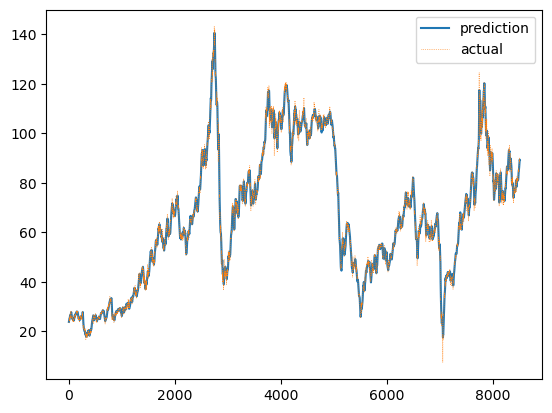

In [377]:
plt.plot(preds, label="prediction")
plt.plot(test_dataset.data[step:], label="actual", ls=":", lw=0.5)
plt.legend()
plt.show()


In [386]:
preds = []  # 예측값들을 저장하는 리스트
pred_model = torch.load(f"oil_price_model_{step}_cuda.pth", map_location=device)
start = dataset[0][0]
with torch.no_grad():
    for i in range(2190):
        pred = pred_model(start.unsqueeze(0).to(device))
        start = torch.cat((start[1:].to(device), pred.unsqueeze(0)))
        preds.append(pred.item())


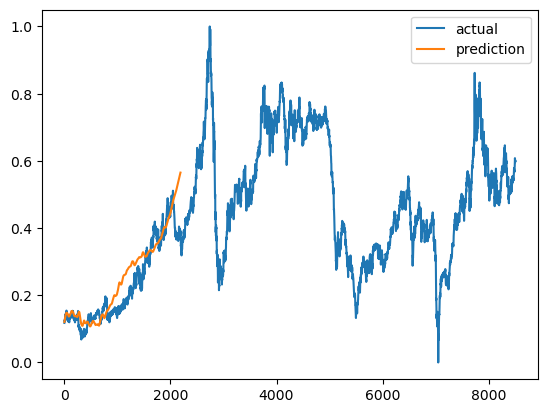

In [387]:
plt.plot(dataset.data[step:], label="actual")
plt.plot(preds, label="prediction")
plt.legend()
plt.show()


In [392]:
preds = []  # 예측값들을 저장하는 리스트
pred_model = torch.load(f"oil_price_model_{step}_cuda.pth", map_location=device)
start = dataset[len(dataset.data[step:])-1][0]
with torch.no_grad():
    for i in range(1825):
        pred = pred_model(start.unsqueeze(0).to(device))
        start = torch.cat((start[1:].to(device), pred.unsqueeze(0)))
        preds.append(pred.item())


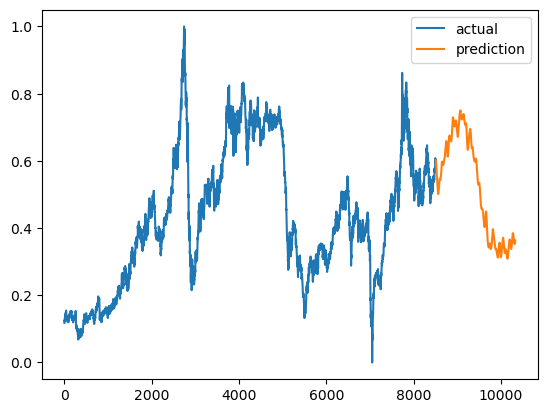

In [393]:
x_1 = np.arange(len(dataset.data[step:]))
x_2 = np.arange(len(preds)) + len(dataset.data[step:])
plt.plot(x_1, dataset.data[step:], label="actual")
plt.plot(x_2, preds, label="prediction")
plt.legend()
plt.show()
